#Тестирование классического подхода обучения на классических архитектурах

В этом ноутбуке используются архитектуры моделей VGG19, ResNet152, DenseNet161, EfficientNetB6, предобученные на датасете ImageNet. Модели обучаются на датасете из соревнования на плтформе Kaggle - https://www.kaggle.com/c/dog-breed-identification/data. Всего 120 классов. 

In [1]:
!nvidia-smi
import torch
torch.cuda.is_available()

Fri Oct 22 12:28:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [2]:
import pickle
import os
import sys
import numpy as np
import pandas as pd
from skimage import io
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from multiprocessing.pool import ThreadPool
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import torch.nn as nn
from matplotlib import colors, pyplot as plt
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=eba7713c4d6c6705c3721e9db829ddc6dff2f0944237635d520a3f5e8100baec
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


Импорт необходимых функций

In [5]:
sys.path.insert(1, '/content/drive/MyDrive/Diplom')
from functions import *

#Подготовка данных

Используется две версии датасета - полная и сокращенная. Цель - сравнить, какая из классических моделей показывает меньшую разницу в итоговом качестве классификации на полном и сокращенном датасетах.

Исходный датасет

In [6]:
!unzip -q /content/drive/MyDrive/Diplom/dog-breed-identification.zip -d dogs

Сокращенный датасет

In [7]:
!unzip -q /content/drive/MyDrive/Diplom/dogs_short_train.zip -d dogs_short

Словарь пород

In [8]:
d = create_labels('/content/dogs/labels.csv')


Полный датасет

In [9]:
TRAIN_DIR = Path('/content/dogs/train')
TEST_DIR = Path('/content/dogs/test')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))

train_val_labels = [d[path.name] for path in train_val_files]

test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
 stratify=train_val_labels)

train_dataset = DogsDataset(train_files, mode='train')

val_dataset = DogsDataset(val_files, mode='val')

test_dataset = DogsDataset(test_files, mode='test')

Сокращенный датасет

In [10]:
TRAIN_DIR_SHORT = Path('/content/dogs_short')

train_val_files_short = sorted(list(TRAIN_DIR_SHORT.rglob('*.jpg')))

train_val_labels_short = [d[path.name] for path in train_val_files_short]

train_files_short, val_files_short = train_test_split(train_val_files_short, test_size=0.25, \
 stratify=train_val_labels_short)

train_dataset_short = DogsDataset(train_files_short, mode='train')

val_dataset_short = DogsDataset(val_files_short, mode='val')

Пример картинок

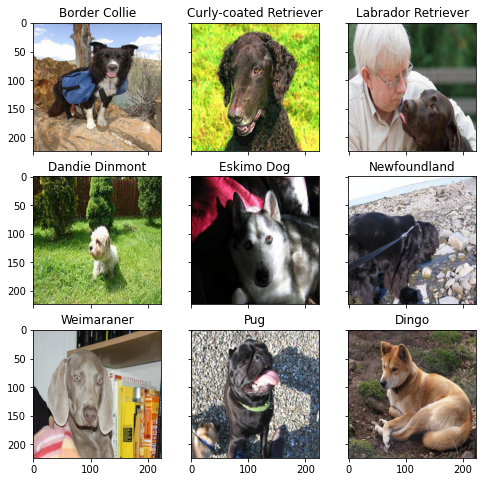

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), sharey=True, sharex=True)
for fig_x in ax.flatten():
 random_characters = int(np.random.uniform(0,1000))
 im_val, label = val_dataset[random_characters]
 img_label = " ".join(map(lambda x: x.capitalize(),\
 val_dataset.label_encoder.inverse_transform([label])[0].split('_')))

 imshow(im_val.data.cpu(), \
 title=img_label,plt_ax=fig_x)

#ResNet 152


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss 3.0911650448656567


epoch:  10%|█         | 1/10 [08:54<1:20:07, 534.13s/it]

Saved model with val acc 0.6987480438184663

Epoch 001 train_loss: 3.0912   val_loss 1.3771 train_acc 0.3912 val_acc 0.6987
loss 0.9551213452873857


epoch:  20%|██        | 2/10 [17:41<1:10:40, 530.04s/it]


Epoch 002 train_loss: 0.9551   val_loss 1.0591 train_acc 0.7041 val_acc 0.6878
loss 0.495745793105478


epoch:  30%|███       | 3/10 [26:28<1:01:42, 528.87s/it]

Saved model with val acc 0.7097026604068858

Epoch 003 train_loss: 0.4957   val_loss 1.0051 train_acc 0.8341 val_acc 0.7097
loss 0.3207707038023377


epoch:  40%|████      | 4/10 [35:13<52:43, 527.22s/it]

Saved model with val acc 0.721830985915493

Epoch 004 train_loss: 0.3208   val_loss 1.0633 train_acc 0.8929 val_acc 0.7218
loss 0.2511047462850397


epoch:  50%|█████     | 5/10 [43:59<43:54, 526.82s/it]

Saved model with val acc 0.7245696400625978

Epoch 005 train_loss: 0.2511   val_loss 1.0119 train_acc 0.9168 val_acc 0.7246
loss 0.22765361005865561


epoch:  60%|██████    | 6/10 [52:43<35:02, 525.68s/it]


Epoch 006 train_loss: 0.2277   val_loss 1.0995 train_acc 0.9212 val_acc 0.7164
loss 0.15858967212326933


epoch:  70%|███████   | 7/10 [1:01:24<26:12, 524.16s/it]

Saved model with val acc 0.7257433489827856

Epoch 007 train_loss: 0.1586   val_loss 1.2142 train_acc 0.9485 val_acc 0.7257
loss 0.14373887831404972


epoch:  80%|████████  | 8/10 [1:10:03<17:25, 522.70s/it]


Epoch 008 train_loss: 0.1437   val_loss 1.0735 train_acc 0.9533 val_acc 0.7250
loss 0.11986352324761798


epoch:  90%|█████████ | 9/10 [1:18:44<08:42, 522.10s/it]


Epoch 009 train_loss: 0.1199   val_loss 1.1819 train_acc 0.9641 val_acc 0.7171
loss 0.10216676357571311


epoch: 100%|██████████| 10/10 [1:27:24<00:00, 524.46s/it]

Saved model with val acc 0.7347417840375587

Epoch 010 train_loss: 0.1022   val_loss 1.2318 train_acc 0.9704 val_acc 0.7347


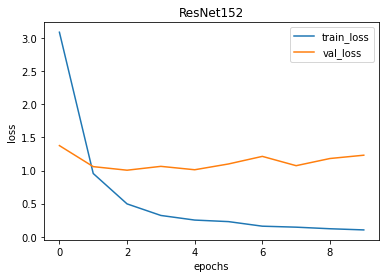

In [ ]:
save_name = '/content/DogsModelRESNET152.pth'
model = initialize_and_train_model("ResNet152", 120, 10, 32, train_dataset, val_dataset, save_name)

In [ ]:
res = make_prediction(save_name, model, test_files)
res.to_csv('/content/drive/MyDrive/Diplom/resnet152_classic.csv', index = False)

Kaggle score 1.18338

**Сокращенный датасет**

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss 4.215383495367744


epoch:  10%|█         | 1/10 [03:05<27:51, 185.69s/it]

Saved model with val acc 0.49222797927461137

Epoch 001 train_loss: 4.2154   val_loss 3.1117 train_acc 0.2047 val_acc 0.4922
loss 1.3686329405007684


epoch:  20%|██        | 2/10 [06:10<24:42, 185.37s/it]

Saved model with val acc 0.6238341968911917

Epoch 002 train_loss: 1.3686   val_loss 1.2763 train_acc 0.6172 val_acc 0.6238
loss 0.6962116341703001


epoch:  30%|███       | 3/10 [09:15<21:35, 185.04s/it]

Saved model with val acc 0.649740932642487

Epoch 003 train_loss: 0.6962   val_loss 1.1944 train_acc 0.7770 val_acc 0.6497
loss 0.3875966675136429


epoch:  40%|████      | 4/10 [12:20<18:29, 184.90s/it]

Saved model with val acc 0.6766839378238342

Epoch 004 train_loss: 0.3876   val_loss 1.1787 train_acc 0.8710 val_acc 0.6767
loss 0.2699987009105841


epoch:  50%|█████     | 5/10 [15:24<15:24, 184.83s/it]

Saved model with val acc 0.6943005181347149

Epoch 005 train_loss: 0.2700   val_loss 1.2070 train_acc 0.9174 val_acc 0.6943
loss 0.19781613955853886


epoch:  60%|██████    | 6/10 [18:28<12:18, 184.53s/it]


Epoch 006 train_loss: 0.1978   val_loss 1.5403 train_acc 0.9367 val_acc 0.6746
loss 0.14557679625096656


epoch:  70%|███████   | 7/10 [21:33<09:13, 184.55s/it]

Saved model with val acc 0.716062176165803

Epoch 007 train_loss: 0.1456   val_loss 1.1394 train_acc 0.9554 val_acc 0.7161
loss 0.1323341936037913


epoch:  80%|████████  | 8/10 [24:37<06:08, 184.36s/it]


Epoch 008 train_loss: 0.1323   val_loss 1.3956 train_acc 0.9616 val_acc 0.6632
loss 0.1283387996431538


epoch:  90%|█████████ | 9/10 [27:41<03:04, 184.31s/it]


Epoch 009 train_loss: 0.1283   val_loss 1.4174 train_acc 0.9654 val_acc 0.6860
loss 0.08224269032045518


epoch: 100%|██████████| 10/10 [30:45<00:00, 184.56s/it]



Epoch 010 train_loss: 0.0822   val_loss 1.6126 train_acc 0.9744 val_acc 0.6415


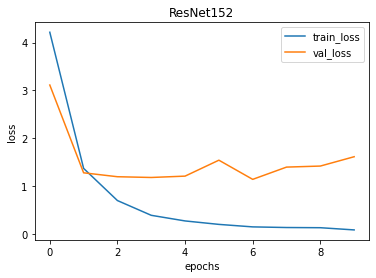

In [ ]:
save_name = '/content/DogsModelRESNET152_short.pth'
model = initialize_and_train_model("ResNet152", 120, 10, 32, train_dataset_short, val_dataset_short, save_name)

In [ ]:
res = make_prediction(save_name, model, test_files)
res.to_csv('/content/drive/MyDrive/Diplom/resnet152_classic_short.csv', index = False)

Kaggle score 1.12304

#VGG19

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 2.3910780200565136


epoch:  10%|█         | 1/10 [06:33<59:02, 393.63s/it]

Saved model with val acc 0.7097026604068858

Epoch 001 train_loss: 2.3911   val_loss 0.9915 train_acc 0.4149 val_acc 0.7097
loss 0.6369092176453799


epoch:  20%|██        | 2/10 [13:06<52:27, 393.43s/it]

Saved model with val acc 0.7206572769953051

Epoch 002 train_loss: 0.6369   val_loss 0.9410 train_acc 0.7935 val_acc 0.7207
loss 0.2615600977780114


epoch:  30%|███       | 3/10 [19:39<45:50, 392.87s/it]

Saved model with val acc 0.7261345852895149

Epoch 003 train_loss: 0.2616   val_loss 1.0296 train_acc 0.9147 val_acc 0.7261
loss 0.16974101634489597


epoch:  40%|████      | 4/10 [26:09<39:10, 391.76s/it]


Epoch 004 train_loss: 0.1697   val_loss 1.2792 train_acc 0.9486 val_acc 0.7027
loss 0.11891299767233578


epoch:  50%|█████     | 5/10 [32:39<32:36, 391.21s/it]


Epoch 005 train_loss: 0.1189   val_loss 1.3157 train_acc 0.9637 val_acc 0.6894
loss 0.06367778268485033


epoch:  60%|██████    | 6/10 [39:09<26:02, 390.74s/it]


Epoch 006 train_loss: 0.0637   val_loss 1.3536 train_acc 0.9817 val_acc 0.7144
loss 0.06760132616201643


epoch:  70%|███████   | 7/10 [45:38<19:30, 390.26s/it]


Epoch 007 train_loss: 0.0676   val_loss 1.4813 train_acc 0.9793 val_acc 0.6952
loss 0.04934295569005902


epoch:  80%|████████  | 8/10 [52:07<12:59, 389.89s/it]


Epoch 008 train_loss: 0.0493   val_loss 1.5423 train_acc 0.9859 val_acc 0.7085
loss 0.061785933308686286


epoch:  90%|█████████ | 9/10 [58:37<06:29, 389.76s/it]


Epoch 009 train_loss: 0.0618   val_loss 1.2658 train_acc 0.9820 val_acc 0.7113
loss 0.038695256558275826


epoch: 100%|██████████| 10/10 [1:05:06<00:00, 390.62s/it]



Epoch 010 train_loss: 0.0387   val_loss 1.3960 train_acc 0.9883 val_acc 0.6831


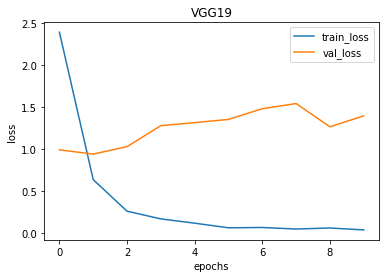

In [ ]:
save_name = '/content/DogsModelVGG19.pth'
model = initialize_and_train_model("VGG19", 120, 10, 32, train_dataset, val_dataset, save_name)

In [ ]:
res = make_prediction(save_name, model, test_files)
res.to_csv('/content/drive/MyDrive/Diplom/vgg19_classic.csv', index = False)

Kaggle score 1.01253

Сокращенный датасет

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 3.8740962798170036


epoch:  10%|█         | 1/10 [02:29<22:26, 149.58s/it]

Saved model with val acc 0.5751295336787564

Epoch 001 train_loss: 3.8741   val_loss 1.6851 train_acc 0.1528 val_acc 0.5751
loss 0.9609583027629931


epoch:  20%|██        | 2/10 [04:59<19:56, 149.58s/it]

Saved model with val acc 0.6290155440414508

Epoch 002 train_loss: 0.9610   val_loss 1.2591 train_acc 0.7203 val_acc 0.6290
loss 0.2730358802348911


epoch:  30%|███       | 3/10 [07:28<17:26, 149.47s/it]

Saved model with val acc 0.633160621761658

Epoch 003 train_loss: 0.2730   val_loss 1.4563 train_acc 0.9149 val_acc 0.6332
loss 0.13818103495475167


epoch:  40%|████      | 4/10 [09:56<14:52, 148.75s/it]


Epoch 004 train_loss: 0.1382   val_loss 1.5710 train_acc 0.9526 val_acc 0.6311
loss 0.09652807029224365


epoch:  50%|█████     | 5/10 [12:26<12:26, 149.21s/it]

Saved model with val acc 0.6435233160621762

Epoch 005 train_loss: 0.0965   val_loss 1.5842 train_acc 0.9710 val_acc 0.6435
loss 0.06500994225250323


epoch:  60%|██████    | 6/10 [14:54<09:55, 148.93s/it]


Epoch 006 train_loss: 0.0650   val_loss 1.6031 train_acc 0.9844 val_acc 0.6352
loss 0.08116701434728371


epoch:  70%|███████   | 7/10 [17:23<07:27, 149.05s/it]

Saved model with val acc 0.6445595854922279

Epoch 007 train_loss: 0.0812   val_loss 1.5665 train_acc 0.9786 val_acc 0.6446
loss 0.037964814326778715


epoch:  80%|████████  | 8/10 [19:51<04:57, 148.72s/it]


Epoch 008 train_loss: 0.0380   val_loss 1.9581 train_acc 0.9865 val_acc 0.6332
loss 0.06254171668200845


epoch:  90%|█████████ | 9/10 [22:19<02:28, 148.30s/it]


Epoch 009 train_loss: 0.0625   val_loss 1.8447 train_acc 0.9848 val_acc 0.6176
loss 0.07154710204784924


epoch: 100%|██████████| 10/10 [24:47<00:00, 148.71s/it]



Epoch 010 train_loss: 0.0715   val_loss 1.6388 train_acc 0.9803 val_acc 0.6228


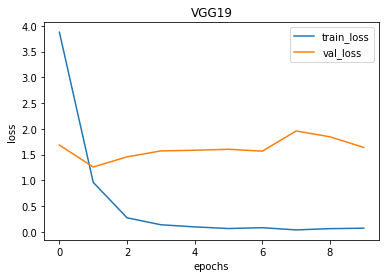

In [ ]:
save_name = '/content/DogsModelVGG19_short.pth'
model = initialize_and_train_model("VGG19", 120, 10, 32, train_dataset_short, val_dataset_short, save_name)

In [ ]:
res = make_prediction(save_name, model, test_files)
res.to_csv('/content/drive/MyDrive/Diplom/vgg19_classic_short.csv', index = False)

Kaggle score 1.47443

#DenseNet161

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 4.156004593511055


epoch:  10%|█         | 1/10 [08:27<1:16:05, 507.25s/it]

Saved model with val acc 0.5755086071987481

Epoch 001 train_loss: 4.1560   val_loss 3.3043 train_acc 0.1782 val_acc 0.5755
loss 1.364111049318948


epoch:  20%|██        | 2/10 [16:49<1:07:14, 504.31s/it]

Saved model with val acc 0.6709702660406885

Epoch 002 train_loss: 1.3641   val_loss 1.1293 train_acc 0.6364 val_acc 0.6710
loss 0.59138079997985


epoch:  30%|███       | 3/10 [25:11<58:42, 503.17s/it]

Saved model with val acc 0.729264475743349

Epoch 003 train_loss: 0.5914   val_loss 0.9579 train_acc 0.8162 val_acc 0.7293
loss 0.32160586332515984


epoch:  40%|████      | 4/10 [33:32<50:14, 502.43s/it]

Saved model with val acc 0.7562597809076682

Epoch 004 train_loss: 0.3216   val_loss 0.9173 train_acc 0.8954 val_acc 0.7563
loss 0.20686723069892116


epoch:  50%|█████     | 5/10 [41:54<41:50, 502.09s/it]


Epoch 005 train_loss: 0.2069   val_loss 0.9202 train_acc 0.9344 val_acc 0.7523
loss 0.14017195856169998


epoch:  60%|██████    | 6/10 [50:16<33:28, 502.12s/it]

Saved model with val acc 0.7711267605633803

Epoch 006 train_loss: 0.1402   val_loss 0.9938 train_acc 0.9567 val_acc 0.7711
loss 0.09319401559454675


epoch:  70%|███████   | 7/10 [58:37<25:05, 501.97s/it]


Epoch 007 train_loss: 0.0932   val_loss 0.9691 train_acc 0.9712 val_acc 0.7711
loss 0.0722162292605937


epoch:  80%|████████  | 8/10 [1:07:00<16:44, 502.16s/it]

Saved model with val acc 0.7773865414710486

Epoch 008 train_loss: 0.0722   val_loss 0.9535 train_acc 0.9785 val_acc 0.7774
loss 0.06104399658012586


epoch:  90%|█████████ | 9/10 [1:15:22<08:22, 502.10s/it]


Epoch 009 train_loss: 0.0610   val_loss 0.9972 train_acc 0.9819 val_acc 0.7649
loss 0.0493857005118795


epoch: 100%|██████████| 10/10 [1:23:43<00:00, 502.32s/it]



Epoch 010 train_loss: 0.0494   val_loss 1.1338 train_acc 0.9857 val_acc 0.7606


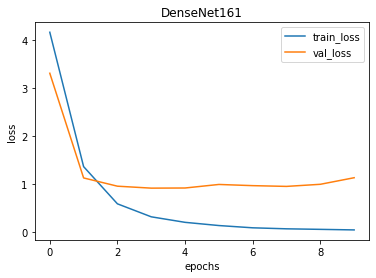

In [ ]:
save_name = '/content/DogsModelDenseNet161.pth'
model = initialize_and_train_model("DenseNet161", 120, 10, 32, train_dataset, val_dataset, save_name)

In [ ]:
res = make_prediction(save_name, model, test_files)
res.to_csv('/content/drive/MyDrive/Diplom/densenet161_classic.csv', index = False)

Kaggle score 1.01522

Сокращенный датасет

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 4.584133253057963


epoch:  10%|█         | 1/10 [03:12<28:49, 192.15s/it]

Saved model with val acc 0.24974093264248703

Epoch 001 train_loss: 4.5841   val_loss 4.0511 train_acc 0.0474 val_acc 0.2497
loss 2.2783268594478012


epoch:  20%|██        | 2/10 [06:22<25:29, 191.18s/it]

Saved model with val acc 0.5222797927461139

Epoch 002 train_loss: 2.2783   val_loss 1.8245 train_acc 0.4530 val_acc 0.5223
loss 0.821021916790457


epoch:  30%|███       | 3/10 [09:33<22:15, 190.81s/it]

Saved model with val acc 0.6093264248704663

Epoch 003 train_loss: 0.8210   val_loss 1.5254 train_acc 0.7600 val_acc 0.6093
loss 0.3576802978212243


epoch:  40%|████      | 4/10 [12:43<19:03, 190.63s/it]

Saved model with val acc 0.6207253886010362

Epoch 004 train_loss: 0.3577   val_loss 1.4964 train_acc 0.8897 val_acc 0.6207
loss 0.17692395529476604


epoch:  50%|█████     | 5/10 [15:53<15:52, 190.42s/it]


Epoch 005 train_loss: 0.1769   val_loss 1.5428 train_acc 0.9454 val_acc 0.6104
loss 0.14032987741184103


epoch:  60%|██████    | 6/10 [19:03<12:41, 190.41s/it]

Saved model with val acc 0.6352331606217616

Epoch 006 train_loss: 0.1403   val_loss 1.4663 train_acc 0.9599 val_acc 0.6352
loss 0.08264192554424742


epoch:  70%|███████   | 7/10 [22:13<09:30, 190.30s/it]


Epoch 007 train_loss: 0.0826   val_loss 1.4442 train_acc 0.9765 val_acc 0.6352
loss 0.08063194517981401


epoch:  80%|████████  | 8/10 [25:24<06:20, 190.26s/it]

Saved model with val acc 0.6373056994818652

Epoch 008 train_loss: 0.0806   val_loss 1.5528 train_acc 0.9775 val_acc 0.6373
loss 0.061909157983742316


epoch:  90%|█████████ | 9/10 [28:34<03:10, 190.17s/it]


Epoch 009 train_loss: 0.0619   val_loss 1.6586 train_acc 0.9844 val_acc 0.6269
loss 0.06100440543933281


epoch: 100%|██████████| 10/10 [31:44<00:00, 190.43s/it]

Saved model with val acc 0.6704663212435232

Epoch 010 train_loss: 0.0610   val_loss 1.4667 train_acc 0.9844 val_acc 0.6705


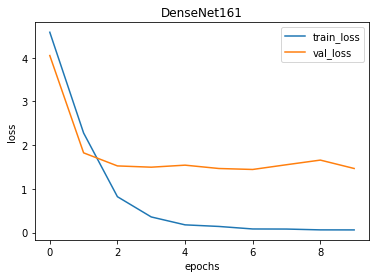

In [ ]:
save_name = '/content/DogsModelDenseNet161_short.pth'
model = initialize_and_train_model("DenseNet161", 120, 10, 32, train_dataset_short, val_dataset_short, save_name)

In [ ]:
res = make_prediction(save_name, model, test_files)
res.to_csv('/content/drive/MyDrive/Diplom/densenet161_classic_short.csv', index = False)

Kaggle score 1.46973

#EfficientNet B6

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b6-c76e70fd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b6-c76e70fd.pth


  0%|          | 0.00/165M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b6


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 4.296197760487672


epoch:  10%|█         | 1/10 [12:46<1:54:59, 766.62s/it]

Saved model with val acc 0.6091549295774648

Epoch 001 train_loss: 4.2962   val_loss 3.2041 train_acc 0.1971 val_acc 0.6092
loss 0.8221543741123564


epoch:  20%|██        | 2/10 [25:22<1:41:23, 760.39s/it]

Saved model with val acc 0.8071205007824727

Epoch 002 train_loss: 0.8222   val_loss 0.6476 train_acc 0.7653 val_acc 0.8071
loss 0.21094148570684798


epoch:  30%|███       | 3/10 [37:58<1:28:27, 758.18s/it]


Epoch 003 train_loss: 0.2109   val_loss 0.7455 train_acc 0.9311 val_acc 0.7969
loss 0.07672819297674711


epoch:  40%|████      | 4/10 [50:33<1:15:42, 757.07s/it]

Saved model with val acc 0.8082942097026604

Epoch 004 train_loss: 0.0767   val_loss 0.7216 train_acc 0.9760 val_acc 0.8083
loss 0.03562672033060066


epoch:  50%|█████     | 5/10 [1:03:14<1:03:12, 758.50s/it]

Saved model with val acc 0.8133802816901409

Epoch 005 train_loss: 0.0356   val_loss 0.8160 train_acc 0.9905 val_acc 0.8134
loss 0.02328825906813101


epoch:  60%|██████    | 6/10 [1:15:54<50:35, 758.81s/it]


Epoch 006 train_loss: 0.0233   val_loss 0.8813 train_acc 0.9936 val_acc 0.8016
loss 0.014728844599208379


epoch:  70%|███████   | 7/10 [1:28:37<38:01, 760.37s/it]

Saved model with val acc 0.8227699530516432

Epoch 007 train_loss: 0.0147   val_loss 0.8565 train_acc 0.9963 val_acc 0.8228
loss 0.005929594720525823


epoch:  80%|████████  | 8/10 [1:41:23<25:24, 762.03s/it]

Saved model with val acc 0.8321596244131455

Epoch 008 train_loss: 0.0059   val_loss 0.8477 train_acc 0.9979 val_acc 0.8322
loss 0.0030316889565674934


epoch:  90%|█████████ | 9/10 [1:54:08<12:43, 763.15s/it]


Epoch 009 train_loss: 0.0030   val_loss 0.8830 train_acc 0.9986 val_acc 0.8318
loss 0.00258760298517014


epoch: 100%|██████████| 10/10 [2:06:55<00:00, 761.52s/it]

Saved model with val acc 0.8337245696400626

Epoch 010 train_loss: 0.0026   val_loss 0.8949 train_acc 0.9988 val_acc 0.8337


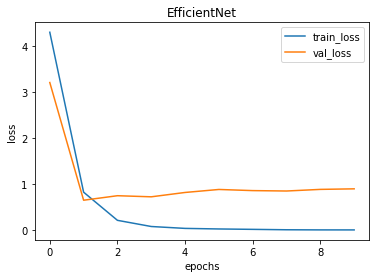

In [ ]:
save_name = '/content/EfficientNetB6.pth'
model = initialize_and_train_model("EfficientNet", 120, 10, 16, train_dataset, val_dataset, save_name)

In [ ]:
res = make_prediction(save_name, model, test_files)
res.to_csv('/content/drive/MyDrive/Diplom/effnet_classic.csv', index = False)

Kaggle score 0.84965

Сокращенный датасет

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b6-c76e70fd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b6-c76e70fd.pth


  0%|          | 0.00/165M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b6


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 4.715212914953588


epoch:  10%|█         | 1/10 [04:48<43:19, 288.84s/it]

Saved model with val acc 0.32642487046632124

Epoch 001 train_loss: 4.7152   val_loss 4.5577 train_acc 0.0477 val_acc 0.3264
loss 2.3039251697013983


epoch:  20%|██        | 2/10 [09:35<38:19, 287.44s/it]

Saved model with val acc 0.7471502590673574

Epoch 002 train_loss: 2.3039   val_loss 0.8865 train_acc 0.5737 val_acc 0.7472
loss 0.38215852155766217


epoch:  30%|███       | 3/10 [14:20<33:23, 286.26s/it]

Saved model with val acc 0.7854922279792745

Epoch 003 train_loss: 0.3822   val_loss 0.7881 train_acc 0.8880 val_acc 0.7855
loss 0.09097168363957958


epoch:  40%|████      | 4/10 [19:04<28:32, 285.37s/it]


Epoch 004 train_loss: 0.0910   val_loss 0.8694 train_acc 0.9706 val_acc 0.7668
loss 0.03625929004604185


epoch:  50%|█████     | 5/10 [23:48<23:45, 285.12s/it]

Saved model with val acc 0.7958549222797927

Epoch 005 train_loss: 0.0363   val_loss 0.8180 train_acc 0.9910 val_acc 0.7959
loss 0.02235578920339256


epoch:  60%|██████    | 6/10 [28:33<18:59, 284.91s/it]

Saved model with val acc 0.7968911917098446

Epoch 006 train_loss: 0.0224   val_loss 0.8601 train_acc 0.9959 val_acc 0.7969
loss 0.004416303395971212


epoch:  70%|███████   | 7/10 [33:18<14:14, 284.92s/it]

Saved model with val acc 0.8113989637305699

Epoch 007 train_loss: 0.0044   val_loss 0.8168 train_acc 0.9997 val_acc 0.8114
loss 0.0008986988229668064


epoch:  80%|████████  | 8/10 [38:03<09:29, 284.91s/it]

Saved model with val acc 0.8165803108808289

Epoch 008 train_loss: 0.0009   val_loss 0.8464 train_acc 1.0000 val_acc 0.8166
loss 0.000520082407442268


epoch:  90%|█████████ | 9/10 [42:47<04:44, 284.72s/it]


Epoch 009 train_loss: 0.0005   val_loss 0.8686 train_acc 1.0000 val_acc 0.8135
loss 0.00037206421804454636


epoch: 100%|██████████| 10/10 [47:32<00:00, 285.22s/it]



Epoch 010 train_loss: 0.0004   val_loss 0.8868 train_acc 1.0000 val_acc 0.8124


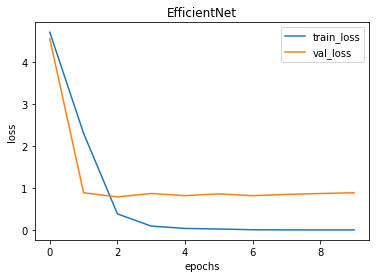

In [11]:
save_name = '/content/EfficientNetB6_short.pth'
model = initialize_and_train_model("EfficientNet", 120, 10, 16, train_dataset_short, val_dataset_short, save_name)

In [12]:
res = make_prediction(save_name, model, test_files)
res.to_csv('/content/drive/MyDrive/Diplom/effnet_classic_short.csv', index = False)

Kaggle score 0.86976